## Data Skew
Reference: https://www.youtube.com/watch?v=9Ss-_y7njKE&list=PLWAuYt0wgRcLCtWzUxNg4BjnYlCZNEVth

Why is data skew bad?  
- Job takes time
- uneven utilization of resource - compute & memory
- Out of Memory errors

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
# Initialize Spark Session
spark = SparkSession.builder.appName("skew").getOrCreate()
sc = spark.sparkContext

### Uniform dataset

In [36]:
sc.setJobDescription("uniform_dataset_1")

uniform_df = spark.range(1000000)
uniform_df.show(3,False)

+---+
|id |
+---+
|0  |
|1  |
|2  |
+---+
only showing top 3 rows



In [37]:
sc.setJobDescription("uniform_dataset_2")

uniform_df.withColumn('partition',spark_partition_id()).groupBy('partition').count().orderBy('partition').show()

+---------+------+
|partition| count|
+---------+------+
|        0|125000|
|        1|125000|
|        2|125000|
|        3|125000|
|        4|125000|
|        5|125000|
|        6|125000|
|        7|125000|
+---------+------+



### Skewed dataset

In [38]:
sc.setJobDescription("skewed_dataset_1")

df0 = spark.range(0, 1000000).repartition(1)
df1 = spark.range(0, 10).repartition(1)
df2 = spark.range(0, 10).repartition(1)
df_skew = df0.union(df1).union(df2)
df_skew.show(3, False)

+---+
|id |
+---+
|0  |
|1  |
|2  |
+---+
only showing top 3 rows



In [39]:
sc.setJobDescription("skewed_dataset_2")

df_skew.withColumn('partition',spark_partition_id()).groupBy('partition').count().orderBy('partition').show()

+---------+-------+
|partition|  count|
+---------+-------+
|        0|1000000|
|        1|     10|
|        2|     10|
+---------+-------+



### Skew Joins

In [40]:
trans_df = spark.read.parquet('../data/transactions.parquet')
cust_df = spark.read.parquet('../data/customers.parquet')

In [41]:
trans_df.printSchema()
trans_df.show(5)

root
 |-- cust_id: string (nullable = true)
 |-- start_date: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- txn_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- expense_type: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- city: string (nullable = true)

+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+-----------+
|   cust_id|start_date|  end_date|         txn_id|      date|year|month|day| expense_type|   amt|       city|
+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+-----------+
|C0YDPQWPBJ|2010-07-01|2018-12-01|TZ5SMKZY9S03OQJ|2018-10-07|2018|   10|  7|Entertainment| 10.42|     boston|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TYIAPPNU066CJ5R|2016-03-27|2016|    3| 27| Motor/Travel| 44.34|   portland|
|C0YDPQWPBJ|2010-07-01|201

In [29]:
cust_df.printSchema()
cust_df.show(5)

root
 |-- cust_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthday: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- city: string (nullable = true)

+----------+-------------+---+------+----------+-----+-----------+
|   cust_id|         name|age|gender|  birthday|  zip|       city|
+----------+-------------+---+------+----------+-----+-----------+
|C007YEYTX9| Aaron Abbott| 34|Female| 7/13/1991|97823|     boston|
|C00B971T1J| Aaron Austin| 37|Female|12/16/2004|30332|    chicago|
|C00WRSJF1Q| Aaron Barnes| 29|Female| 3/11/1977|23451|     denver|
|C01AZWQMF3|Aaron Barrett| 31|  Male|  7/9/1998|46613|los_angeles|
|C01BKUFRHA| Aaron Becker| 54|  Male|11/24/1979|40284|  san_diego|
+----------+-------------+---+------+----------+-----+-----------+
only showing top 5 rows



In [30]:
sc.setJobDescription("countdistinct")

trans_df.groupBy('cust_id').agg(countDistinct('txn_id').alias('ct')).orderBy(desc('ct')).show(5)

24/12/15 13:50:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/15 13:50:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/15 13:50:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/15 13:50:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/15 13:50:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/15 13:50:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/15 13:50:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/15 13:50:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/15 13:50:34 WARN RowBasedKeyValueBatch: Calling spill() on

+----------+--------+
|   cust_id|      ct|
+----------+--------+
|C0YDPQWPBJ|17539732|
|CBW3FMEAU7|    7999|
|C3KUDEN3KO|    7999|
|C89FCEGPJP|    7999|
|CHNFNR89ZV|    7998|
+----------+--------+
only showing top 5 rows



In [42]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [43]:
spark.conf.set("spark.sql.adaptive.enabled", "false")

In [44]:
sc.setJobDescription("skew_join_1")

txn_details_df = trans_df.join(cust_df,on='cust_id',how='inner')

In [45]:
sc.setJobDescription("skew_join_2")

import time
start_time = time.time()
txn_details_df.count()
print(f"time taken: {time.time() - start_time}")

time taken: 8.766127109527588


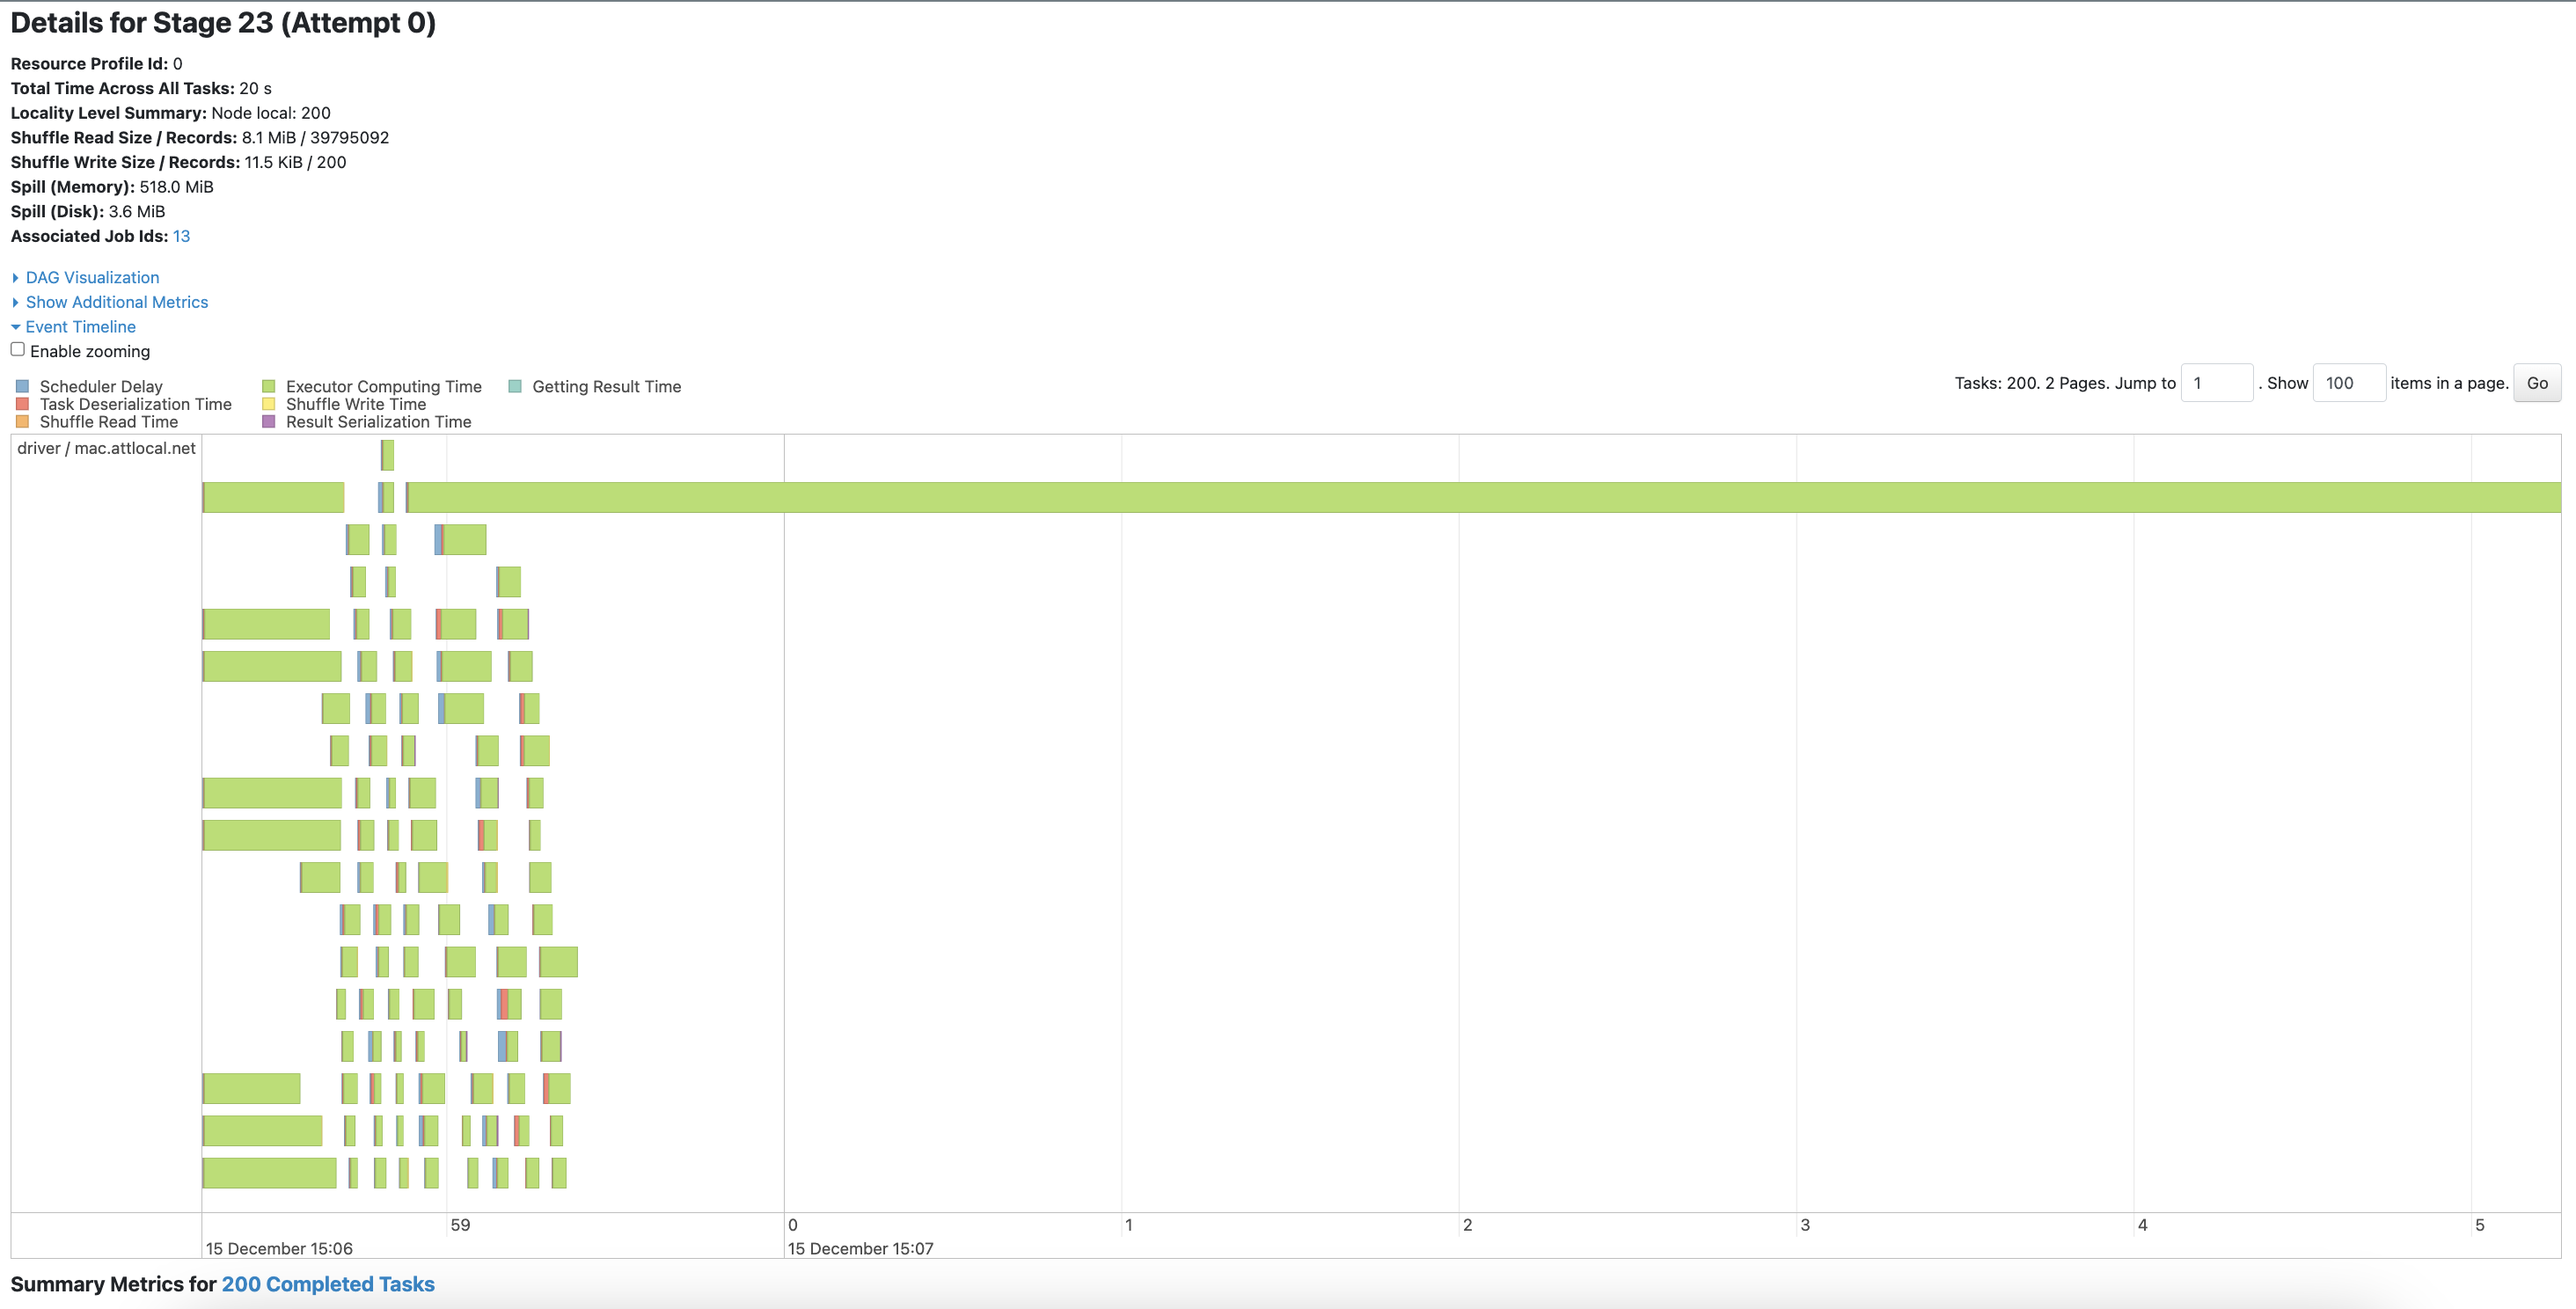

In [46]:
from IPython.display import Image
Image(filename='../UI_screenshots/skew/skew.png',width=1100,height=10)

In [34]:
spark.stop()